
# Multiple signals from same single-cell simulation

In [1]:
%matplotlib inline
import sys
import os
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.patches import Ellipse
import elephant
import neuron
from neuron import h
import LFPy
from lfpykit.eegmegcalc import FourSphereVolumeConductor

np.random.seed(12345)

tstop = 100
dt = 2**-5
sigma = 0.3


In [2]:
# If cell model does not exist, we download it:
if not os.path.isfile('L5bPCmodelsEH/morphologies/cell1.asc'):
    from urllib.request import urlopen
    import ssl
    import zipfile
    #get the model files:
    u = urlopen('http://senselab.med.yale.edu/ModelDB/eavBinDown.asp?o=139653&a=23&mime=application/zip',
                context=ssl._create_unverified_context())
    localFile = open('L5bPCmodelsEH.zip', 'wb')
    localFile.write(u.read())
    localFile.close()
    #unzip:
    myzip = zipfile.ZipFile('L5bPCmodelsEH.zip', 'r')
    myzip.extractall('.')
    myzip.close()

#compile mod files every time, because of incompatibility with Mainen96 files:
if "win32" in sys.platform:
    from warnings import warn
    pth = "L5bPCmodelsEH/mod/"
    warn("no autompile of NMODL (.mod) files on Windows.\n" 
         + "Run mknrndll from NEURON bash in the folder L5bPCmodelsEH/mod and rerun example script")
    if not pth in neuron.nrn_dll_loaded:
        neuron.h.nrn_load_dll(pth+"nrnmech.dll")
    neuron.nrn_dll_loaded.append(pth)
else:
    os.system('''
              cd L5bPCmodelsEH/mod/
              nrnivmodl
              ''')
    neuron.load_mechanisms('L5bPCmodelsEH/mod/')
    

cellParameters = {
    'morphology'    : 'L5bPCmodelsEH/morphologies/cell1.asc',
    'templatefile'  : ['L5bPCmodelsEH/models/L5PCbiophys3.hoc',
                       'L5bPCmodelsEH/models/L5PCtemplate.hoc'],
    'templatename'  : 'L5PCtemplate',
    'templateargs'  : 'L5bPCmodelsEH/morphologies/cell1.asc',
    'passive' : False,
    'nsegs_method' : None,
    'dt' : dt,
    'tstart' : -200,
    'tstop' : tstop,
    'v_init' : -60,
    'celsius': 34,
    'pt3d' : True,
}

/home/tone/work/tutorial_at_EBRAINS/LFPy_examples/L5bPCmodelsEH/mod
Mod files: "./CaDynamics_E2.mod" "./Ca_HVA.mod" "./Ca_LVAst.mod" "./epsp.mod" "./Ih.mod" "./Im.mod" "./K_Pst.mod" "./K_Tst.mod" "./Nap_Et2.mod" "./NaTa_t.mod" "./NaTs2_t.mod" "./SK_E2.mod" "./SKv3_1.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


In [3]:
def insert_synaptic_input(cell, synidx, spiketime, syn_e, weight_factor):

    synapse_parameters = dict(
                          idx = synidx,
                          e = syn_e, # reversal potential
                          weight = 0.005 * weight_factor, # synapse weight
                          record_current = False, # record synapse current
                          syntype = 'Exp2Syn',
                          tau1 = 0.1, #Time constant, rise
                          tau2 = 1.0, #Time constant, decay
                          )
    synapse = LFPy.Synapse(cell, **synapse_parameters)
    synapse.set_spike_times(np.array([spiketime]))
    return synapse, cell


# delete old sections from NEURON namespace
LFPy.cell.neuron.h("forall delete_section()")

# Initialize cell instance, using the LFPy.TemplateCell class
cell = LFPy.TemplateCell(**cellParameters)
cell.set_rotation(x=4.729, y=-3.166)

# Adding some basal excitatory input:
num_syns = 250
synidxs = cell.get_rand_idx_area_norm(section='allsec', 
                                      z_max=200, z_min=-200, 
                                      nidx=num_syns)
syn_times = np.random.normal(50, 15, size=num_syns)
syn_e = 0
weight_factor = 0.25
for idx in range(num_syns):
    synapse, cell = insert_synaptic_input(cell, synidxs[idx], 
                                          syn_times[idx], 
                                          syn_e, weight_factor)

# Adding soma apical inhibitory input:
num_syns = 250
synidxs = cell.get_rand_idx_area_norm(section='allsec', 
                                      z_max=2000, z_min=800, 
                                      nidx=num_syns)
syn_times = np.random.normal(50, 15, size=num_syns)
syn_e = -90
weight_factor = 0.5
for idx in range(num_syns):
    synapse, cell = insert_synaptic_input(cell, synidxs[idx], 
                                          syn_times[idx], 
                                          syn_e, weight_factor)

cell.simulate(rec_imem=True, rec_vmem=True)


numprocs=1


In [4]:
# LFP is low-pass filtered, and EAP is high-pass filtered:
filt_dict_hf = {'highpass_freq': 500,
                 'lowpass_freq': None,
                 'order': 4,
                 'filter_function': 'filtfilt',
                 'fs': 1 / dt * 1000,
                 'axis': -1}

filt_dict_lf = {'highpass_freq': None,
                 'lowpass_freq': 200,
                 'order': 4,
                 'filter_function': 'filtfilt',
                 'fs': 1 / dt * 1000,
                 'axis': -1}

# Make one recoring locations close to the soma, 
# and one close to the apical dendrite:
elec_params = dict(
            sigma = sigma,      # extracellular conductivity
            x = np.array([-20, 100]),
            y = np.zeros(2),
            z = np.array([0, 800]),
            method = 'root_as_point',
        )
elec = LFPy.RecExtElectrode(cell, **elec_params)
M_elec = elec.get_transformation_matrix()

v_e = M_elec @ cell.imem * 1000
v_e -= v_e[:, 0, None]

eap = elephant.signal_processing.butter(v_e[0], **filt_dict_hf)
lfp = elephant.signal_processing.butter(v_e[1], **filt_dict_lf)

# EEG signal from four-sphere head model:
radii = [89000., 90000., 95000., 100000.]  # (µm)
sigmas = [0.276, 1.65, 0.01, 0.465]  # (S/m)
eps = 1e-2
x = np.array([0])
y = np.array([0])
z = np.array([radii[-1] - eps])

r_elecs = np.array([x, y, z]).T # (µm)
sphere_model = FourSphereVolumeConductor(r_elecs, radii, sigmas)
cdm = LFPy.CurrentDipoleMoment(cell).get_transformation_matrix() @ cell.imem

somapos = np.array([0., 0., radii[0] - np.max(cell.z) - 100])
r_soma_syns = [cell.get_intersegment_vector(idx0=0, idx1=i)
               for i in cell.synidx]
r_mid = np.average(r_soma_syns, axis=0)
r_mid = somapos + r_mid/2.

M_eeg = sphere_model.get_transformation_matrix(r_mid)  
eeg = elephant.signal_processing.butter(1e6 * M_eeg @ cdm, **filt_dict_lf) # (nV)


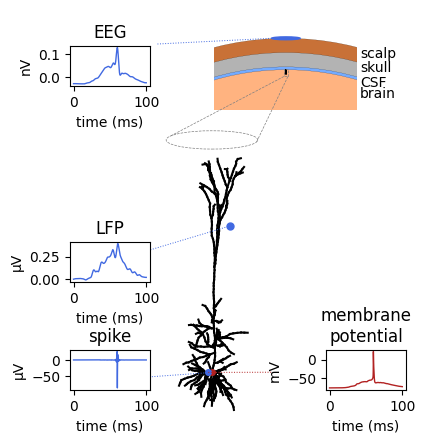

In [5]:
eeg_clr = 'royalblue'
eap_clr = 'royalblue'
lfp_clr = 'royalblue'
vm_clr = 'firebrick'

xmin = -155
xmax = 220
zmin = -160
zmax = 1150

def plot_four_sphere_model(ax, radii):
    head_colors = ["#ffb380", "#74abff", "#b3b3b3", "#c87137"]
    for i in range(4):
        ax.add_patch(plt.Circle((0, 0), radius=radii[-1 - i],
                                   color=head_colors[-1-i],
                                   fill=True, ec='k', lw=.1))
    # mark 4-sphere head model layers
    ax.text(26000, radii[0] - 6000, 'brain', ha="left", va="top", rotation=-0)
    ax.text(26000, radii[1] - 3000, 'CSF', ha="left", va="top", rotation=-0)
    ax.text(26000, radii[2] - 3000, 'skull', ha="left", va="top", rotation=-0)
    ax.text(26000, radii[3] - 3000, 'scalp', ha="left", va="top", rotation=-0)

fig = plt.figure(figsize=[4, 4])
fig.subplots_adjust(bottom=0.05, top=0.98, left=0.01, right=0.99, wspace=0.2)

ax_m = fig.add_axes([0.3, 0.05, 0.4, 0.6], frameon=False, aspect=1,
                        xticks=[], yticks=[], xlim=[xmin, xmax],
                        ylim=[zmin, zmax])

ax_4s = fig.add_axes([0.42, 0.78, 0.5, 0.25], frameon=False, aspect=1,
                    xticks=[], yticks=[], xlim=[-25000, 25000], 
                     ylim=[75000, 110000])

plot_four_sphere_model(ax_4s, radii)

ax_vm = fig.add_axes([0.77, 0.08, 0.2, 0.1], 
                     title="membrane\npotential", 
                     xlabel="time (ms)", ylabel="mV")
ax_eap = fig.add_axes([0.13, 0.08, 0.2, 0.1], 
                      title="spike", xlabel="time (ms)", ylabel="µV")
ax_lfp = fig.add_axes([0.13, 0.35, 0.2, 0.1], 
                      title="LFP", xlabel="time (ms)", ylabel="µV")
ax_eeg = fig.add_axes([0.13, 0.84, 0.2, 0.1], 
                      title="EEG", xlabel="time (ms)", ylabel="nV")


t1 = 20
t1_idx = np.argmin(np.abs(cell.tvec - t1))

num_elecs = len(elec.x)
max_v_e = np.max(np.abs(v_e))

ax_m.plot(cell.x.T, cell.z.T, c='k', clip_on=False)
ax_4s.plot(cell.x.T, cell.z.T + radii[0] - np.max(cell.z) - 20, 
           c='k', clip_on=False, lw=0.7)

ax_eap.plot(cell.tvec, eap, c=eap_clr, lw=1.)
ax_lfp.plot(cell.tvec, lfp, c=lfp_clr, lw=1.)
ax_eeg.plot(cell.tvec, eeg[0], c=eeg_clr, lw=1.)


ax_vm.plot(cell.tvec, cell.vmem[0, :], c=vm_clr, lw=1.)
    
ax_m.plot(cell.x[0].mean(), cell.z[0].mean(), 'o', 
          c=vm_clr, ms=4)
ax_m.plot([cell.x[0].mean(), cell.x[0].mean()- 350], 
          [cell.z[0].mean(), cell.z[0].mean() - 25], 
          ":", clip_on=False, c=eap_clr, lw=0.7)

ax_m.plot(elec.x[0], elec.z[0], 'o', c=eap_clr, ms=4)
ax_m.plot([elec.x[0], elec.x[0] + 350], 
          [elec.z[0], elec.z[0] + 1], 
          ":", clip_on=False, c=vm_clr, lw=0.7)
    
ax_m.plot(elec.x[1], elec.z[1], 'o', c=lfp_clr, 
          ms=5, clip_on=False)

el2 = Ellipse((r_elecs[0, 0], r_elecs[0, 2]), 
             10000, 1000, edgecolor=eeg_clr, lw=1,
             facecolor=eeg_clr, clip_on=False)
ax_4s.add_artist(el2)


ax_m.plot([elec.x[1], elec.x[1] - 500], 
          [elec.z[1], elec.z[1] - 150], 
          ":", clip_on=False, c=lfp_clr, lw=0.7)
    


ax_4s.plot([r_elecs[0, 0] - 5000, r_elecs[0, 0] - 45000], 
          [r_elecs[0, 2], r_elecs[0, 2] - 2000], 
          ":", clip_on=False, c=eeg_clr, lw=0.7)


# Cell inset location lines
z0 = radii[0] - np.max(cell.z) - 200
ax_4s.plot([-700, 700, 700, -700, -700], 
           np.array([-1000, -1000, 1500, 1500, -1000]) + z0, 
           lw=0.5, c='gray', ls='--')

ax_4s.plot([-700, -700 - 40000],
           [-1000 + z0, + z0 - 22000], 
           lw=0.5, c='gray', ls="--", clip_on=False)

ax_4s.plot([+700, +700 - 11000],
           [-1000 + z0, + z0 - 24000], 
           lw=0.5, c='gray', ls="--", clip_on=False)

el3 = Ellipse((0, np.max(cell.z) + 100), 
             500, 100, edgecolor='gray', ls='--', lw=0.5,
             facecolor='none', clip_on=False)
ax_m.add_artist(el3)


fig.savefig(join("hay_multisignal.pdf"))